In [9]:
import xarray
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
import matplotlib as mpl
import warnings
# Add a couple of deep down individual functions.
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import AutoMinorLocator
import cmasher as cmr
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FormatStrFormatter

In [2]:
def get_cordex_addresses():
    models = pd.read_csv('/home/theo/cordex_models.txt', sep='\t')
    root = '/data/met/ukcordex/'
    directories = [root + models['GCM'][i] + '/' +
                   models['RCM'][i] + '/' +
                   models['Ensemble'][i] + '/dmo/'
                   for i in range(models.shape[0])]
    tas_files  = []
    hurs_files = []
    pr_files   = []
    wind_files = []
    err_indexs = []
    print(type(err_indexs))
    for i in range(models.shape[0]):
        try:
            for f_name in os.listdir(directories[i]):
                if f_name.startswith('tas_'):
                    tas_files.append(str(f_name))
                if f_name.startswith('hurs_'):
                    hurs_files.append(str(f_name))
                if f_name.startswith('sfcWind_'):
                    wind_files.append(str(f_name))
                if f_name.startswith('pr_'):
                    pr_files.append(str(f_name))
        except OSError as error:
            print(f'Inelligible directory at: {directories[i]}')
            err_indexs.append(int(i))
    for i in range(len(err_indexs)-1,-1,-1):
        del directories[err_indexs[i]]
    return directories,tas_files,hurs_files,wind_files,pr_files

In [28]:
region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
region_mask = region_data.admin_region
region_mask = np.nan_to_num(region_mask)
mask = np.logical_not(region_mask == 0).astype('float')
mask[mask == False] = np.nan

In [34]:
tags = ['01','04','05','06','07','08','09','10','11','12','13','15']

tas_ukcp_map = np.zeros((128,108))
hur_ukcp_map = np.zeros((128,108))
wnd_ukcp_map = np.zeros((128,108))
prc_ukcp_map = np.zeros((128,108))
tas_ukcp_max = np.zeros((128,108))
wnd_ukcp_max = np.zeros((128,108))

for i in range(len(tags)):
    print(f'Model: {i+1} of {len(tags)}')
    tas_data  = xarray.open_dataset(f'/home/theo/data/ukcp18/tas_rcp85_ukcp18_natgb_{tags[i]}_day_19801201-20801130.nc')
    hur_data = xarray.open_dataset(f'/home/theo/data/ukcp18/hurs_rcp85_ukcp18_natgb_{tags[i]}_day_19801201-20801130.nc')
    wnd_data = xarray.open_dataset(f'/home/theo/data/ukcp18/sfcWind_rcp85_ukcp18_natgb_{tags[i]}_day_19801201-20801130.nc')
    prc_data = xarray.open_dataset(f'/home/theo/data/ukcp18/pr_rcp85_ukcp18_natgb_{tags[i]}_day_19801201-20801130.nc')
    
    try:
        years = np.array(pd.to_datetime(np.array(tas_data.time)).year)
        months = np.array(pd.to_datetime(np.array(tas_data.time)).month)
    except:
        years = np.vectorize(lambda x: x.year) (np.array(tas_data.time))
        months = np.vectorize(lambda x: x.month) (np.array(tas_data.time))
    
    year_inds = np.where(years >= 2061)
    summer_inds=np.concatenate((np.where(months == 6)[0],np.where(months == 7)[0],np.where(months == 8)[0]),axis = 0)
    summer_indices = np.intersect1d(year_inds,summer_inds).astype(int)

    tas_ukcp_map = (np.mean(np.array(tas_data.tas[summer_indices,:,:,0]),axis=0)        + tas_ukcp_map)*mask
    hur_ukcp_map = (np.mean(np.array(hur_data.hurs[summer_indices,:,:,0]),axis=0)       + hur_ukcp_map)*mask
    wnd_ukcp_map = (np.mean(np.array(wnd_data.sfcWind[summer_indices,:,:,0])*3.6,axis=0)+ wnd_ukcp_map)*mask
    prc_ukcp_map = (np.mean(np.array(prc_data.pr[summer_indices,:,:,0]),axis=0)         + prc_ukcp_map)*mask
    tas_ukcp_max = (np.max(np.array(tas_data.tas[summer_indices,:,:,0]),axis=0)         + tas_ukcp_max)*mask
    wnd_ukcp_max = (np.max(np.array(wnd_data.sfcWind[summer_indices,:,:,0])*3.6,axis=0) + wnd_ukcp_max)*mask
    
    
tas_ukcp_map = tas_ukcp_map / len(tags)
hur_ukcp_map = hur_ukcp_map / len(tags)
wnd_ukcp_map = wnd_ukcp_map / len(tags)
prc_ukcp_map = prc_ukcp_map / len(tags)
tas_ukcp_max = tas_ukcp_max / len(tags)
wnd_ukcp_max = wnd_ukcp_max / len(tags)

print('\n\n\n')
print(np.nanmean(tas_ukcp_map))
print(np.nanmean(hur_ukcp_map))
print(np.nanmean(wnd_ukcp_map))
print(np.nanmean(prc_ukcp_map))
print(np.nanmean(tas_ukcp_max))
print(np.nanmean(wnd_ukcp_max))

Model: 1 of 12
Model: 2 of 12
Model: 3 of 12
Model: 4 of 12
Model: 5 of 12
Model: 6 of 12
Model: 7 of 12
Model: 8 of 12
Model: 9 of 12
Model: 10 of 12
Model: 11 of 12
Model: 12 of 12




18.252601194314646
74.11409680652217
12.709738391361153
2.123476762063345
29.35096902762979
33.84288162286439


In [35]:
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()

tas_cord_map = np.zeros((128,108))
hur_cord_map = np.zeros((128,108))
wnd_cord_map = np.zeros((128,108))
prc_cord_map = np.zeros((128,108))
tas_cord_max = np.zeros((128,108))
wnd_cord_max = np.zeros((128,108))

for i in range(1,len(directories)):
    print(f'Model: {i} of {len(directories)}')
    tas_data  = xarray.open_dataset(directories[i] + tas_files[i], engine = "netcdf4")
    hur_data  = xarray.open_dataset(directories[i] + hurs_files[i], engine = "netcdf4")
    prc_data  = xarray.open_dataset(directories[i] + pr_files[i], engine = "netcdf4")
    wnd_data  = xarray.open_dataset(directories[i] + wind_files[i], engine = "netcdf4")
    
    try:
        years = np.array(pd.to_datetime(np.array(tas_data.time)).year)
        months = np.array(pd.to_datetime(np.array(tas_data.time)).month)
    except:
        years = np.vectorize(lambda x: x.year) (np.array(tas_data.time))
        months = np.vectorize(lambda x: x.month) (np.array(tas_data.time))
    
    year_inds = np.where(years >= 2061)
    summer_inds=np.concatenate((np.where(months == 6)[0],np.where(months == 7)[0],np.where(months == 8)[0]),axis = 0)
    summer_indices = np.intersect1d(year_inds,summer_inds).astype(int)
    
    #print(tas_cord_map.shape)
    #print(np.mean(tas_data.tas[summer_indices,:,:],axis=0).shape)
    #print(mask.shape)
    
    tas_cord_map = (np.mean(np.array(tas_data.tas[summer_indices,:,:]) - 273.15,axis=0) + tas_cord_map)*mask
    hur_cord_map = (np.mean(np.array(hur_data.hurs[summer_indices,:,:])        ,axis=0) + hur_cord_map)*mask
    wnd_cord_map = (np.mean(np.array(wnd_data.sfcWind[summer_indices,:,:])*3.6 ,axis=0) + wnd_cord_map)*mask
    prc_cord_map = (np.mean(np.array(prc_data.pr[summer_indices,:,:])*86400    ,axis=0) + prc_cord_map)*mask
    tas_cord_max = (np.max(np.array(tas_data.tas[summer_indices,:,:]) - 273.15 ,axis=0) + tas_cord_max)*mask
    wnd_cord_max = (np.max(np.array(wnd_data.sfcWind[summer_indices,:,:])*3.6  ,axis=0) + wnd_cord_max)*mask
    
    del tas_data,hur_data,wnd_data,prc_data
    
tas_cord_map = tas_cord_map / len(directories)
hur_cord_map = hur_cord_map / len(directories)
wnd_cord_map = wnd_cord_map / len(directories)
prc_cord_map = prc_cord_map / len(directories)
tas_cord_max = tas_cord_max / len(directories)
wnd_cord_max = wnd_cord_max / len(directories)

print('\n\n\n')
print(np.nanmean(tas_cord_map))
print(np.nanmean(hur_cord_map))
print(np.nanmean(wnd_cord_map))
print(np.nanmean(prc_cord_map))
print(np.nanmean(tas_cord_max))
print(np.nanmean(wnd_cord_max))

<class 'list'>
Model: 1 of 49
Model: 2 of 49
Model: 3 of 49
Model: 4 of 49
Model: 5 of 49
Model: 6 of 49
Model: 7 of 49
Model: 8 of 49
Model: 9 of 49
Model: 10 of 49
Model: 11 of 49
Model: 12 of 49
Model: 13 of 49
Model: 14 of 49
Model: 15 of 49
Model: 16 of 49
Model: 17 of 49
Model: 18 of 49
Model: 19 of 49
Model: 20 of 49
Model: 21 of 49
Model: 22 of 49
Model: 23 of 49
Model: 24 of 49
Model: 25 of 49
Model: 26 of 49
Model: 27 of 49
Model: 28 of 49
Model: 29 of 49
Model: 30 of 49
Model: 31 of 49
Model: 32 of 49
Model: 33 of 49
Model: 34 of 49
Model: 35 of 49
Model: 36 of 49
Model: 37 of 49
Model: 38 of 49
Model: 39 of 49
Model: 40 of 49
Model: 41 of 49
Model: 42 of 49
Model: 43 of 49
Model: 44 of 49
Model: 45 of 49
Model: 46 of 49
Model: 47 of 49
Model: 48 of 49




15.701501477295682
78.78008746304255
15.14136763562592
2.711921650100612
24.868449424811878
39.883100143265374


In [41]:
print(max(np.nanmax(tas_cord_map),np.nanmax(tas_ukcp_map)))
print(min(np.nanmin(tas_cord_map),np.nanmin(tas_ukcp_map)))
print('\n')
print(max(np.nanmax(hur_cord_map),np.nanmax(hur_ukcp_map)))
print(min(np.nanmin(hur_cord_map),np.nanmin(hur_ukcp_map)))
print('\n')
print(max(np.nanmax(wnd_cord_map),np.nanmax(wnd_ukcp_map)))
print(min(np.nanmin(wnd_cord_map),np.nanmin(wnd_ukcp_map)))
print('\n')
print(max(np.nanmax(prc_cord_map),np.nanmax(prc_ukcp_map)))
print(min(np.nanmin(prc_cord_map),np.nanmin(prc_ukcp_map)))
print('\n')
print(max(np.nanmax(tas_cord_max),np.nanmax(tas_ukcp_max)))
print(min(np.nanmin(tas_cord_max),np.nanmin(tas_ukcp_max)))
print('\n')
print(max(np.nanmax(wnd_cord_max),np.nanmax(wnd_ukcp_max)))
print(min(np.nanmin(wnd_cord_max),np.nanmin(wnd_ukcp_max)))

22.9773055712382
11.338131943527532


88.38111305236816
54.202521006266274


24.449873447418213
7.445984522501628


8.197325309117636
0.7171677798032761


35.45703379313151
18.357731410435267


62.730247497558594
23.55428409576416


In [ ]:
[11,15,19,23]


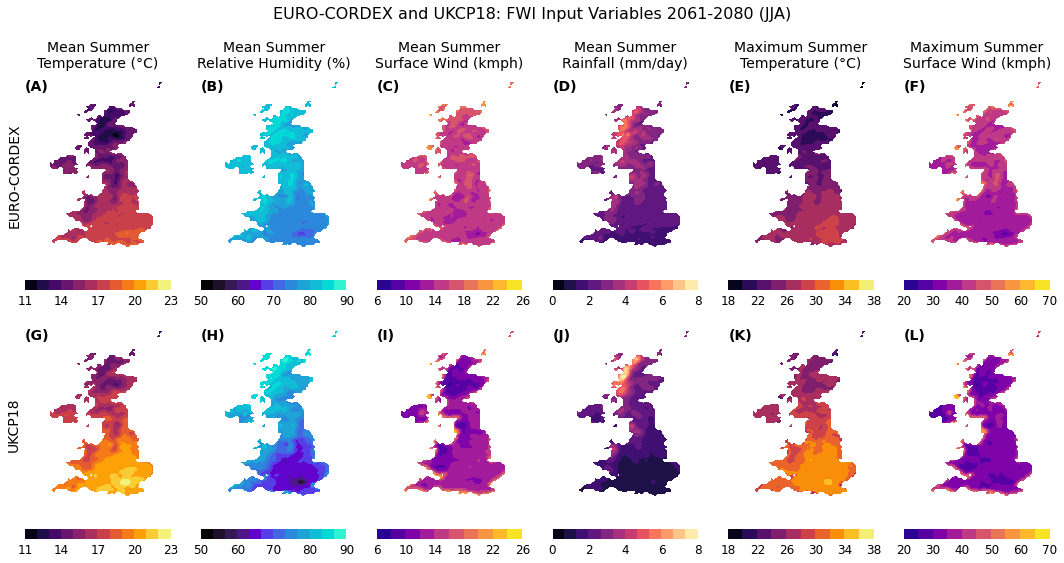

In [56]:
fig, axs = plt.subplots(2,6)
fig.set_figheight(8)
fig.set_figwidth(15)
fig.suptitle('EURO-CORDEX and UKCP18: FWI Input Variables 2061-2080 (JJA)', fontsize=16)


levels = np.linspace(11, 23, 12+1)
axs[0,0].set_title('Mean Summer\nTemperature (°C)',fontsize=14)
data00 = (tas_cord_map)[5:115,20:85]
c00 = axs[0,0].contourf(data00,cmap=plt.get_cmap('inferno'),levels=levels)
axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)
axs[0,0].spines['bottom'].set_visible(False)
axs[0,0].spines['left'].set_visible(False)
axs[0,0].get_xaxis().set_ticks([])
axs[0,0].get_yaxis().set_ticks([])
axs[0,0].set_ylabel('EURO-CORDEX',fontsize=14)
axs[0,0].text(0,100, '(A)', size=14,weight='bold')
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb00 = fig.colorbar(c00, cax=cax, orientation='horizontal',ticks=[11,14,17,20,23])
cb00.outline.set_visible(False)
cb00.ax.tick_params(length=0,labelsize=12)
#cb00.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cb00.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
data01 = (tas_ukcp_map)[5:115,20:85]
c01 = axs[1,0].contourf(data01,cmap=plt.get_cmap('inferno'),levels=levels)
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['bottom'].set_visible(False)
axs[1,0].spines['left'].set_visible(False)
axs[1,0].get_xaxis().set_ticks([])
axs[1,0].get_yaxis().set_ticks([])
axs[1,0].set_ylabel('UKCP18',fontsize=14)
axs[1,0].text(0,100, '(G)', size=14,weight='bold')
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb01 = fig.colorbar(c01, cax=cax, orientation='horizontal',ticks=[11,14,17,20,23])
cb01.outline.set_visible(False)
cb01.ax.tick_params(length=0,labelsize=12)
#cb01.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cb01.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))


levels = np.linspace(50, 90, 12+1)
axs[0,1].set_title('Mean Summer\nRelative Humidity (%)',fontsize=14)
data10 = (hur_cord_map)[5:115,20:85]
c10 = axs[0,1].contourf(data10,cmap=plt.get_cmap('cmr.cosmic'),levels=levels)
axs[0,1].text(0,100, '(B)', size=14,weight='bold')
axs[0,1].axis('off')
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb10 = fig.colorbar(c10, cax=cax, orientation='horizontal',ticks=[50,60,70,80,90])
cb10.outline.set_visible(False)
cb10.ax.tick_params(length=0,labelsize=12)
data11 = (hur_ukcp_map)[5:115,20:85]
c11 = axs[1,1].contourf(data11,cmap=plt.get_cmap('cmr.cosmic'),levels=levels)
axs[1,1].text(0,100, '(H)', size=14,weight='bold')
axs[1,1].axis('off')
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb11 = fig.colorbar(c11, cax=cax, orientation='horizontal',ticks=[50,60,70,80,90])
cb11.outline.set_visible(False)
cb11.ax.tick_params(length=0,labelsize=12)



levels = np.linspace(6, 26, 10+1)
axs[0,2].set_title('Mean Summer\nSurface Wind (kmph)',fontsize=14)
data20 = (wnd_cord_map)[5:115,20:85]
c20 = axs[0,2].contourf(data20,cmap=plt.get_cmap('plasma'),levels=levels)
axs[0,2].text(0,100, '(C)', size=14,weight='bold')
axs[0,2].axis('off')
divider = make_axes_locatable(axs[0,2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb20 = fig.colorbar(c20, cax=cax, orientation='horizontal',ticks=[6,10,14,18,22,26])
cb20.outline.set_visible(False)
cb20.ax.tick_params(length=0,labelsize=12)
#cb20.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cb20.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
data21 = (wnd_ukcp_map)[5:115,20:85]
c21 = axs[1,2].contourf(data21,cmap=plt.get_cmap('plasma'),levels=levels)
axs[1,2].text(0,100, '(I)', size=14,weight='bold')
axs[1,2].axis('off')
divider = make_axes_locatable(axs[1,2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb21 = fig.colorbar(c21, cax=cax, orientation='horizontal',ticks=[6,10,14,18,22,26])
cb21.outline.set_visible(False)
cb21.ax.tick_params(length=0,labelsize=12)
#cb21.ax.xaxis.set_major_locator(MaxNLocator(integer=True))   [7,11,15,19,23]     []
cb21.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))



levels = np.linspace(0, 8, 12+1)
axs[0,3].set_title('Mean Summer\nRainfall (mm/day)',fontsize=14)
data30 = (prc_cord_map)[5:115,20:85]
c30 = axs[0,3].contourf(data30,cmap=plt.get_cmap('magma'),levels=levels)
axs[0,3].text(0,100, '(D)', size=14,weight='bold')
axs[0,3].axis('off')
divider = make_axes_locatable(axs[0,3])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb30 = fig.colorbar(c30, cax=cax, orientation='horizontal',ticks=[0,2,4,6,8])
cb30.outline.set_visible(False)
cb30.ax.tick_params(length=0,labelsize=12)
#cb30.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cb30.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
data31 = (prc_ukcp_map)[5:115,20:85]
c31 = axs[1,3].contourf(data31,cmap=plt.get_cmap('magma'),levels=levels)
axs[1,3].text(0,100, '(J)', size=14,weight='bold')
axs[1,3].axis('off')
divider = make_axes_locatable(axs[1,3])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb31 = fig.colorbar(c31, cax=cax, orientation='horizontal',ticks=[0,2,4,6,8])
cb31.outline.set_visible(False)
cb31.ax.tick_params(length=0,labelsize=12)
#cb31.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cb31.ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))


levels = np.linspace(18, 38, 10+1)
axs[0,4].set_title('Maximum Summer\nTemperature (°C)',fontsize=14)
data40 = (tas_cord_max)[5:115,20:85]
c40 = axs[0,4].contourf(data40,cmap=plt.get_cmap('inferno'),levels=levels)
axs[0,4].spines['top'].set_visible(False)
axs[0,4].spines['right'].set_visible(False)
axs[0,4].spines['bottom'].set_visible(False)
axs[0,4].spines['left'].set_visible(False)
axs[0,4].get_xaxis().set_ticks([])
axs[0,4].get_yaxis().set_ticks([])
axs[0,4].text(0,100, '(E)', size=14,weight='bold')
divider = make_axes_locatable(axs[0,4])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb40 = fig.colorbar(c40, cax=cax, orientation='horizontal',ticks=[18,22,26,30,34,38])
cb40.outline.set_visible(False)
cb40.ax.tick_params(length=0,labelsize=12)
data41 = (tas_ukcp_max)[5:115,20:85]
c41 = axs[1,4].contourf(data41,cmap=plt.get_cmap('inferno'),levels=levels)
axs[1,4].spines['top'].set_visible(False)
axs[1,4].spines['right'].set_visible(False)
axs[1,4].spines['bottom'].set_visible(False)
axs[1,4].spines['left'].set_visible(False)
axs[1,4].get_xaxis().set_ticks([])
axs[1,4].get_yaxis().set_ticks([])
axs[1,4].text(0,100, '(K)', size=14,weight='bold')
divider = make_axes_locatable(axs[1,4])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb41 = fig.colorbar(c41, cax=cax, orientation='horizontal',ticks=[18,22,26,30,34,38])
cb41.outline.set_visible(False)
cb41.ax.tick_params(length=0,labelsize=12)


levels = np.linspace(20, 70, 10+1)
axs[0,5].set_title('Maximum Summer\nSurface Wind (kmph)',fontsize=14)
data50 = (wnd_cord_max)[5:115,20:85]
c50 = axs[0,5].contourf(data50,cmap=plt.get_cmap('plasma'),levels=levels)
axs[0,5].text(0,100, '(F)', size=14,weight='bold')
axs[0,5].axis('off')
divider = make_axes_locatable(axs[0,5])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb50 = fig.colorbar(c50, cax=cax, orientation='horizontal',ticks=[20,30,40,50,60,70])
cb50.outline.set_visible(False)
cb50.ax.tick_params(length=0,labelsize=12)
data51 = (wnd_ukcp_max)[5:115,20:85]
c51 = axs[1,5].contourf(data51,cmap=plt.get_cmap('plasma'),levels=levels)
axs[1,5].text(0,100, '(L)', size=14,weight='bold')
axs[1,5].axis('off')
divider = make_axes_locatable(axs[1,5])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
cb51 = fig.colorbar(c51, cax=cax, orientation='horizontal',ticks=[20,30,40,50,60,70])
cb51.outline.set_visible(False)
cb51.ax.tick_params(length=0,labelsize=12)


plt.tight_layout(pad=1.5)
plt.savefig('/home/theo/final_images/1.1.images/combo_map')